In [ ]:
!python --version

Python 3.11.13


In [ ]:
!pip install kagglehub
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [ ]:
from pycaret.regression import *

In [ ]:
from pycaret.datasets import get_data

In [ ]:
import kagglehub

path = kagglehub.competition_download("house-prices-advanced-regression-techniques")

print("Path a la carpeta del dataset: ", path)

100%|██████████| 199k/199k [00:00<00:00, 39.2MB/s]

Extracting files...
Path a la carpeta del dataset:  /root/.cache/kagglehub/competitions/house-prices-advanced-regression-techniques


In [ ]:
import os

if len(dataset_csv:=os.listdir(path)) == 1:
  dataset_index = 0
else:
  print(f"Mas de un dataset encontrado en {path}")
  print(dataset_csv)
  dataset_index = int(input(f"Seleccionar indice del dataset a trabajar [0 - {len(dataset_csv) - 1}]: "))

Mas de un dataset encontrado en /root/.cache/kagglehub/competitions/house-prices-advanced-regression-techniques
['test.csv', 'data_description.txt', 'sample_submission.csv', 'train.csv']
Seleccionar indice del dataset a trabajar [0 - 3]: 3


In [ ]:
import pandas as pd

houses_ds = get_data(os.path.join(path, dataset_csv[dataset_index]).replace('.csv', ''))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print(houses_ds.shape)

(1460, 81)


In [ ]:
houses_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
exp = setup(data=houses_ds, numeric_imputation='median', target='SalePrice', session_id=9999)

/usr/local/lib/python3.11/dist-packages/pycaret/internal/pipeline.py:289: UserWarning: Persisting input arguments took 0.74s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, y = self._memory_full_transform(


,Description,Value
0,Session id,9999
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 81)"
4,Transformed data shape,"(1460, 281)"
5,Transformed train set shape,"(1021, 281)"
6,Transformed test set shape,"(439, 281)"
7,Numeric features,37
8,Categorical features,43
9,Rows with missing values,100.0%


In [ ]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,16476.4260,881052329.9889,28380.7174,0.8610,0.1331,0.0936,1.4590
lightgbm,Light Gradient Boosting Machine,17123.2504,893867090.0975,29108.3887,0.8587,0.1343,0.0946,1.4370
rf,Random Forest Regressor,18160.4845,968480054.7941,30115.7232,0.8468,0.1445,0.1039,3.1980
xgboost,Extreme Gradient Boosting,18084.3843,963022112.8596,30110.3842,0.8461,0.1442,0.1028,1.3750
et,Extra Trees Regressor,18125.7272,1011525415.8099,30688.7569,0.8385,0.1417,0.1018,3.3970
llar,Lasso Least Angle Regression,18071.9861,1265376648.1872,32081.1915,0.8066,0.1495,0.1042,0.6630
ridge,Ridge Regression,19132.0284,1304316606.8621,33189.7514,0.7958,0.1784,0.1106,0.6720
lasso,Lasso Regression,19224.1681,1293877628.3691,33366.7975,0.7948,0.1673,0.1133,0.9820
lr,Linear Regression,19579.5947,1381961241.6995,34491.2226,0.7815,0.2013,0.1157,1.7680
ada,AdaBoost Regressor,24549.8543,1410023016.2605,36859.7484,0.7744,0.1982,0.1563,1.1960


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pycaret/internal/pycaret_experiment/supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


In [ ]:
print("Best model is: ", best_model)

Best model is:  GradientBoostingRegressor(random_state=9999)


In [ ]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14421.7832,474559847.6590,21784.3946,0.9051,0.1071,0.0787
1,17122.1552,1003417918.1941,31676.7725,0.8877,0.1160,0.0820
2,14683.2215,504105514.0981,22452.2942,0.9239,0.1303,0.0918
3,16326.4671,683699941.8569,26147.6565,0.8774,0.1235,0.0887
4,15793.8014,495376976.0960,22257.0658,0.9004,0.1160,0.0855
5,19596.9846,2723119847.2191,52183.5208,0.5969,0.1816,0.1168
6,17634.6471,801802262.9326,28316.1131,0.8714,0.1633,0.1109
7,17260.1810,852415151.5218,29196.1496,0.8472,0.1370,0.0974
8,17278.4054,836253873.6660,28918.0545,0.8902,0.1473,0.1000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15410.8329,495551393.5736,22260.9837,0.9009,0.1149,0.0895
1,19886.6061,1303591432.6206,36105.2826,0.8541,0.1316,0.0970
2,16336.0517,545788175.7722,23362.1098,0.9176,0.1391,0.1035
3,17596.5089,756637626.4101,27507.0469,0.8643,0.1317,0.0947
4,18494.5934,607311996.1718,24643.7009,0.8779,0.1351,0.1022
5,20245.7525,2082546147.8038,45634.9225,0.6917,0.1825,0.1228
6,19113.5201,886661019.4401,29776.8538,0.8578,0.1671,0.1180
7,20025.3888,1039396112.0104,32239.6667,0.8137,0.1467,0.1136
8,17708.6207,959691854.3948,30978.8937,0.8740,0.1470,0.1001


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


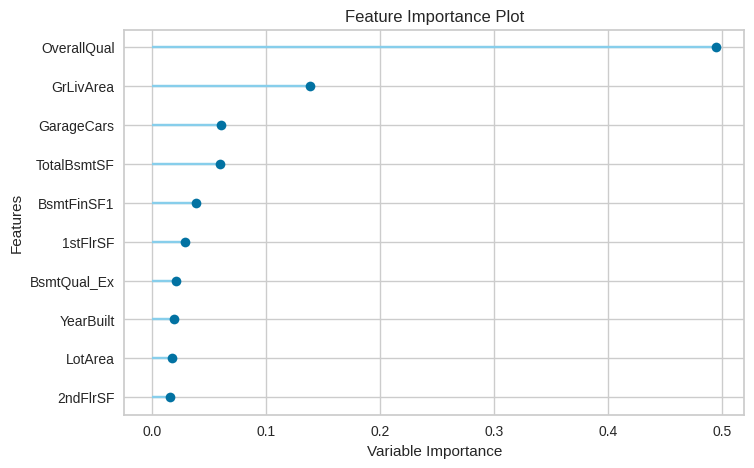

In [ ]:
plot_model(tuned_model, plot='feature')

In [ ]:
predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15698.0774,844146106.2308,29054.1926,0.8680,0.1415,0.0993


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,prediction_label
957,958,20,RL,70.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2007,WD,Normal,132000,135812.704005
784,785,75,RM,35.0,6300,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2008,WD,Normal,128000,139662.601290
192,193,20,RL,68.0,9017,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2009,WD,Normal,192000,199437.118163
607,608,20,RL,78.0,7800,Pave,NaN,Reg,Bnk,AllPub,...,NaN,NaN,NaN,0,8,2006,WD,Normal,225000,166475.109666
90,91,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,109900,106015.949990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,30,RL,67.0,5604,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Normal,98000,99115.716841
815,816,20,RL,48.0,12137,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2010,WD,Normal,224900,207612.869663
669,670,30,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,137500,116382.494019
62,63,120,RL,44.0,6442,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2007,WD,Normal,202500,218557.722435


In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                             'LotArea', 'OverallQual',
                                             'OverallCond', 'YearBuilt',
                                             'YearRemodAdd', 'MasVnrArea',
                                             'BsmtFinSF1', 'BsmtFinSF2',
                                             'BsmtUnfSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF',
                                             'LowQualFinSF', 'GrLivArea',
                                             'BsmtFullBath', 'BsmtHalfBath',
                                             'FullBath', 'Hal...
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                           

In [ ]:
save_model(final_model,'final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                              'LotArea', 'OverallQual',
                                              'OverallCond', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'BsmtFullBath', 'BsmtHalfBath',
                                              'FullBath', 'Hal...
                                                                     'Exterior1st',
                                                                     'Exterior2nd',
             

In [ ]:
# For testing
import json
record = json.loads(houses_ds_train.iloc[0].to_json())
payload = json.dumps([record])
print(payload)

In [ ]:
!pip show pycaret

Name: pycaret
Version: 3.3.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: category-encoders, cloudpickle, deprecation, imbalanced-learn, importlib-metadata, ipython, ipywidgets, jinja2, joblib, kaleido, lightgbm, markupsafe, matplotlib, nbformat, numba, numpy, pandas, plotly, plotly-resampler, pmdarima, psutil, pyod, requests, schemdraw, scikit-learn, scikit-plot, scipy, sktime, statsmodels, tbats, tqdm, wurlitzer, xxhash, yellowbrick
Required-by: 
